In [728]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns             
import datetime
pd.set_option('display.max_rows', 500)
%matplotlib inline

In [730]:
# Source: http://web.mta.info/developers/turnstile.html
def get_data(week_nums):
    dfs = []
    for week_num in week_nums:
        file="/Users/poonamgaikar/metis/turnstile_"+str(week_num)+".txt"
        dfs.append(pd.read_csv(file))
    return pd.concat(dfs)
        
week_nums = [210515, 210522, 210529,210605,210612,210619,210626,210703,210710,210717,210724,210731]
df = get_data(week_nums)

In [731]:
# Data cleaning

In [732]:
df.columns = df.columns.str.replace(' ', '') #removed spaces rename column

In [733]:
station_mask = (
                (df["STATION"] == "ATLANTIC AV") |
                (df["STATION"] == "FLATBUSH AV-B.C")|
                (df["STATION"] == "ATL AV-BARCLAY")|
                (df["STATION"] == "25 AV")|
                (df["STATION"] == "BERGEN ST")|
                (df["STATION"] == "FULTON ST")|
                (df["STATION"] == "LAFAYETTE AV")
               )
station_mask

0         False
1         False
2         False
3         False
4         False
          ...  
209458    False
209459    False
209460    False
209461    False
209462    False
Name: STATION, Length: 2512647, dtype: bool

In [734]:
ss=df[station_mask]

In [735]:
ss=ss.drop(columns=['LINENAME','DIVISION','DESC']) #droped unwated columns

In [736]:
ss["TURNSTILE"]=ss[ "C/A"]+ss["UNIT"]+ss["SCP"]+ss["STATION"]

In [737]:
ss[(ss["TURNSTILE"] =="N098R02800-02-01FULTON ST") &
    ((ss["DATE"] == "07/28/2021") |
     (ss["DATE"] == "07/27/2021"))]

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS,TURNSTILE
64101,N098,R028,00-02-01,FULTON ST,07/27/2021,03:00:00,500540,477111,N098R02800-02-01FULTON ST
64102,N098,R028,00-02-01,FULTON ST,07/27/2021,07:00:00,500547,477147,N098R02800-02-01FULTON ST
64103,N098,R028,00-02-01,FULTON ST,07/27/2021,11:00:00,500619,477315,N098R02800-02-01FULTON ST
64104,N098,R028,00-02-01,FULTON ST,07/27/2021,15:00:00,10,2,N098R02800-02-01FULTON ST
64105,N098,R028,00-02-01,FULTON ST,07/27/2021,19:00:00,251,136,N098R02800-02-01FULTON ST
64106,N098,R028,00-02-01,FULTON ST,07/27/2021,23:00:00,331,220,N098R02800-02-01FULTON ST
64107,N098,R028,00-02-01,FULTON ST,07/28/2021,03:00:00,350,237,N098R02800-02-01FULTON ST
64108,N098,R028,00-02-01,FULTON ST,07/28/2021,07:00:00,355,263,N098R02800-02-01FULTON ST
64109,N098,R028,00-02-01,FULTON ST,07/28/2021,11:00:00,440,504,N098R02800-02-01FULTON ST
64110,N098,R028,00-02-01,FULTON ST,07/28/2021,15:00:00,535,637,N098R02800-02-01FULTON ST


In [738]:
ss = (ss.groupby(
    ["TURNSTILE","DATE","STATION"],
    as_index=False).ENTRIES.first())

In [739]:
ss[["PREV_DATE", "PREV_ENTRIES"]] = (ss.groupby(["TURNSTILE"])["DATE", "ENTRIES"].apply(lambda grp: grp.shift(1)))

/var/folders/w6/39bqqg4n2fgfbdxwjd1r1_rw0000gs/T/ipykernel_43898/2752554790.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ss[["PREV_DATE", "PREV_ENTRIES"]] = (ss.groupby(["TURNSTILE"])["DATE", "ENTRIES"].apply(lambda grp: grp.shift(1)))


In [740]:
ss[(ss["TURNSTILE"] =="N098R02800-02-01FULTON ST") &
    ((ss["DATE"] == "07/28/2021") |
     (ss["DATE"] == "07/27/2021"))]

,TURNSTILE,DATE,STATION,ENTRIES,PREV_DATE,PREV_ENTRIES
5120,N098R02800-02-01FULTON ST,07/27/2021,FULTON ST,500540,07/26/2021,500074.0
5121,N098R02800-02-01FULTON ST,07/28/2021,FULTON ST,350,07/27/2021,500540.0


In [741]:
# Drop the rows for the earliest date in the df
ss.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [742]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        return 0
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits


In [743]:
ss["DAILY_ENTRIES"]= ss.apply(get_daily_counts, axis=1, max_counter=100000)

94 765803.0
350 500540.0
327680 786526.0
327680 0.0
432 11851565.0
24 1925928.0
327683 50346231.0


In [744]:
ss["DATE_TIME"]=pd.to_datetime(ss["DATE"])

In [745]:
ss["WEEK"]=ss["DATE_TIME"].dt.isocalendar().week

In [746]:
ss["DAY"]=ss["DATE_TIME"].dt.dayofweek

In [747]:
MASK=((ss["DAY"] == 0) |
      (ss["DAY"] == 1) |
      (ss["DAY"] == 2) |
      (ss["DAY"] == 3) |
      (ss["DAY"] == 4) 
     )

In [748]:
ss=ss[MASK]

In [751]:
VOLUME_PER_STATION=ss.groupby(["WEEK","STATION"])["DAILY_ENTRIES"].sum().reset_index()

In [752]:
VOLUME_PER_STATION

,WEEK,STATION,DAILY_ENTRIES
0,19,25 AV,8325.0
1,19,ATL AV-BARCLAY,66979.0
2,19,ATLANTIC AV,3688.0
3,19,BERGEN ST,21211.0
4,19,FLATBUSH AV-B.C,32710.0
5,19,FULTON ST,99147.0
6,19,LAFAYETTE AV,7380.0
7,20,25 AV,8497.0
8,20,ATL AV-BARCLAY,68922.0
9,20,ATLANTIC AV,3721.0


In [753]:
VOLUME_PER_WEEK=ss.groupby(["WEEK"])["DAILY_ENTRIES"].sum().reset_index()

In [754]:
VOLUME_PER_WEEK.head(50)

,WEEK,DAILY_ENTRIES
0,19,239440.0
1,20,247241.0
2,21,259870.0
3,22,234758.0
4,23,273032.0
5,24,280513.0
6,25,275106.0
7,26,262514.0
8,27,248976.0
9,28,275186.0


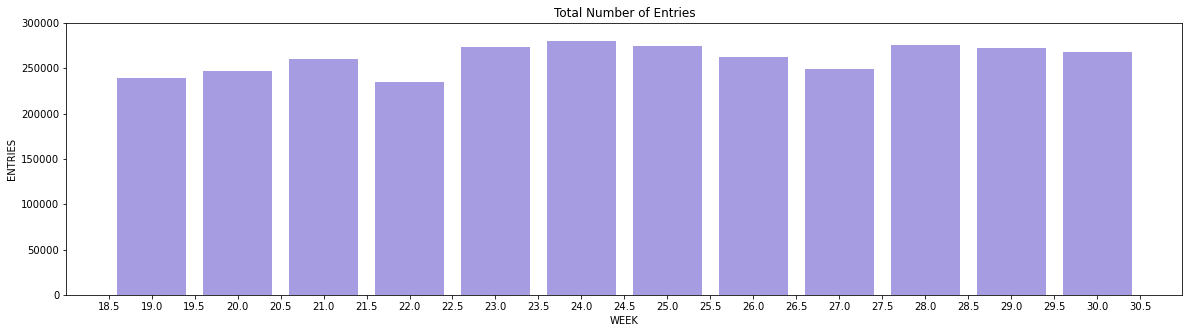

In [755]:
plt.figure(figsize=(20,5))
# plt.fill_between(WEEKLY_ENTRIES['WEEK'], WEEKLY_ENTRIES['ENTRIES'], color='skyblue', alpha=0.5)
plt.bar(VOLUME_PER_WEEK['WEEK'], VOLUME_PER_WEEK['DAILY_ENTRIES'], color="Slateblue", alpha=0.6)
plt.xlabel('WEEK')
plt.ylabel('ENTRIES')
plt.ylim(0,300000)
plt.title('Total Number of Entries')
plt.locator_params(axis='x', nbins=40)
plt.ticklabel_format(axis="y", style="plain");